In [1]:
### import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import cv2

from kluppspy.devices import thermostat as thm
from kluppspy.devices.esp32 import cam
from kluppspy.cv import utils as cvu

In [2]:
# Test images dir
dir_path = "../images/Kar39Thermostat/"

ims = cam.dir_images(dir_path)
im = next(ims)

In [ ]:
region_ims = thm.extract_regions(im)
temperature = region_ims['temperature']
temperature = cv2.cvtColor(temperature, cv2.COLOR_BGR2GRAY)
temperature = cv2.copyMakeBorder(temperature, 0, 0, 0, 20, cv2.BORDER_REPLICATE)
M = np.float32([[1, 0.28, 0], [0, 1  , 0], [0, 0  , 1]])
temperature = cv2.warpPerspective(temperature,M, (temperature.shape[1], temperature.shape[0]))
temperature = temperature[:, 55:]
temperature[155:190, 245:280] = temperature[120:155, 245:280]
temperature = cvu.scale_im(temperature, height=85)
temperature = cv2.bilateralFilter(temperature, 50, 3, 30, borderType=cv2.BORDER_REPLICATE)

temperature = 255 - temperature
temperature = cvu.scale_im(temperature, height=85)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5, 5))
temperature = clahe.apply(temperature)
temperature = cv2.equalizeHist(temperature)
kernel = np.ones((16,16),np.uint8)
temperature = cv2.morphologyEx(temperature, cv2.MORPH_TOPHAT, kernel)
_, temperature = cv2.threshold(temperature, 50, 255, cv2.THRESH_BINARY)
kernel = np.ones((4, 4),np.uint8)
temperature = cv2.morphologyEx(temperature, cv2.MORPH_OPEN, kernel)
kernel = np.ones((7, 7),np.uint8)
temperature = cv2.morphologyEx(temperature, cv2.MORPH_CLOSE, kernel)
plt.imshow(temperature, cmap='gray')

In [ ]:
def extract_temperature_digits(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# #     im = cvu.scale_im(im, scale=0.3)
#     print(im.shape)
    
    # Histogram
#     clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5, 5))
#     im = clahe.apply(im)
    
#     im = cv2.equalizeHist(im)
    
#     im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
# 	cv2.THRESH_BINARY_INV, 65, 65)
#     im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    kernel = np.ones((35,35),np.uint8)
    im = 255 - im

    im = cv2.morphologyEx(im, cv2.MORPH_TOPHAT, kernel)
    _, im = cv2.threshold(im, 8, 255, cv2.THRESH_BINARY)
    im = cv2.copyMakeBorder(im, 0, 0, 0, 40, cv2.BORDER_CONSTANT, None, 0)
    
    # Remove itallic from the font
    M = np.float32([[1, 0.28, 0], 
                    [0, 1  , 0], 
                    [0, 0  , 1]])
    im = cv2.warpPerspective(im,M, (im.shape[1], im.shape[0]))
    im[150:190, 300:335] = 0
    kernel = np.ones((8, 8),np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((20, 20),np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    
#     plt.imshow(im, cmap='gray')
    
    cnts, _ = cv2.findContours(im.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=lambda cnt: cnt[0, 0, 0], reverse = False)

    digits = {}
    for (i, c) in enumerate(cnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        hull = cv2.convexHull(c, False)
        peri = cv2.arcLength(hull, True)
        if peri < 300:
            continue
        (x, y, w, h) = cv2.boundingRect(c)
        digit = im[y:y + h, x:x + w]
#         roi = cv2.resize(roi, (57, 88))
        # update the digits dictionary, mapping the digit name to the ROI
        digits[i] = digit
        
    new_digits = {}
    for i in range(len(digits)):
        digit = digits[i]
        border = digits[2].shape[1] - digit.shape[1]
        if border > 10:
            digit = cv2.copyMakeBorder(digit, 0, 0, border, 0, cv2.BORDER_CONSTANT, None, (0, 0, 0))
        kernel = np.ones((10,10),np.uint8)
#         font = cv2.morphologyEx(digit, cv2.MORPH_TOPHAT, kernel)
        digit = cv2.morphologyEx(digit, cv2.MORPH_CLOSE, kernel)
        new_digits[i] = cv2.resize(digit, (57, 88))
    return new_digits
    
digits = extract_temperature_digits(region_ims['temperature'])

f, axes = plt.subplots(1, 3, sharey=True, figsize=(30, 5))
for idx, ax in enumerate(axes):
    ax.imshow(digits[idx], cmap='gray')
    
plt.tight_layout()

In [ ]:
# loop over the digit contours
def get_thermostat_temperature(im):
    template_digits = get_calculator_digits()
    digits = extract_temperature_digits(im)
    groupOutput = []
    for digit in digits.values():
        scores = []
        for template in template_digits.values():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(digit, template, cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
        # the classification for the digit ROI will be the reference
        # digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
    if len(groupOutput) == 3:
        return float(''.join(groupOutput)) / 10
    return None

In [5]:
def thermostat_temp_test(im):
    BLACK = (255,0,0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 6
    font_color = BLACK
    font_thickness = 15

    region_ims = thm.extract_regions(im)
    temperature = thm.get_temperature(region_ims['temperature'])
    final_im = im.copy()
    text = str(temperature)
    im_with_text = cv2.putText(final_im, text, (100, 200), font, font_size, font_color, font_thickness, cv2.LINE_AA)
    return im_with_text


Process Images



100%|██████████| 12/12 [00:00<00:00, 26.39it/s]


Show Images



100%|██████████| 12/12 [00:00<00:00, 37.76it/s]


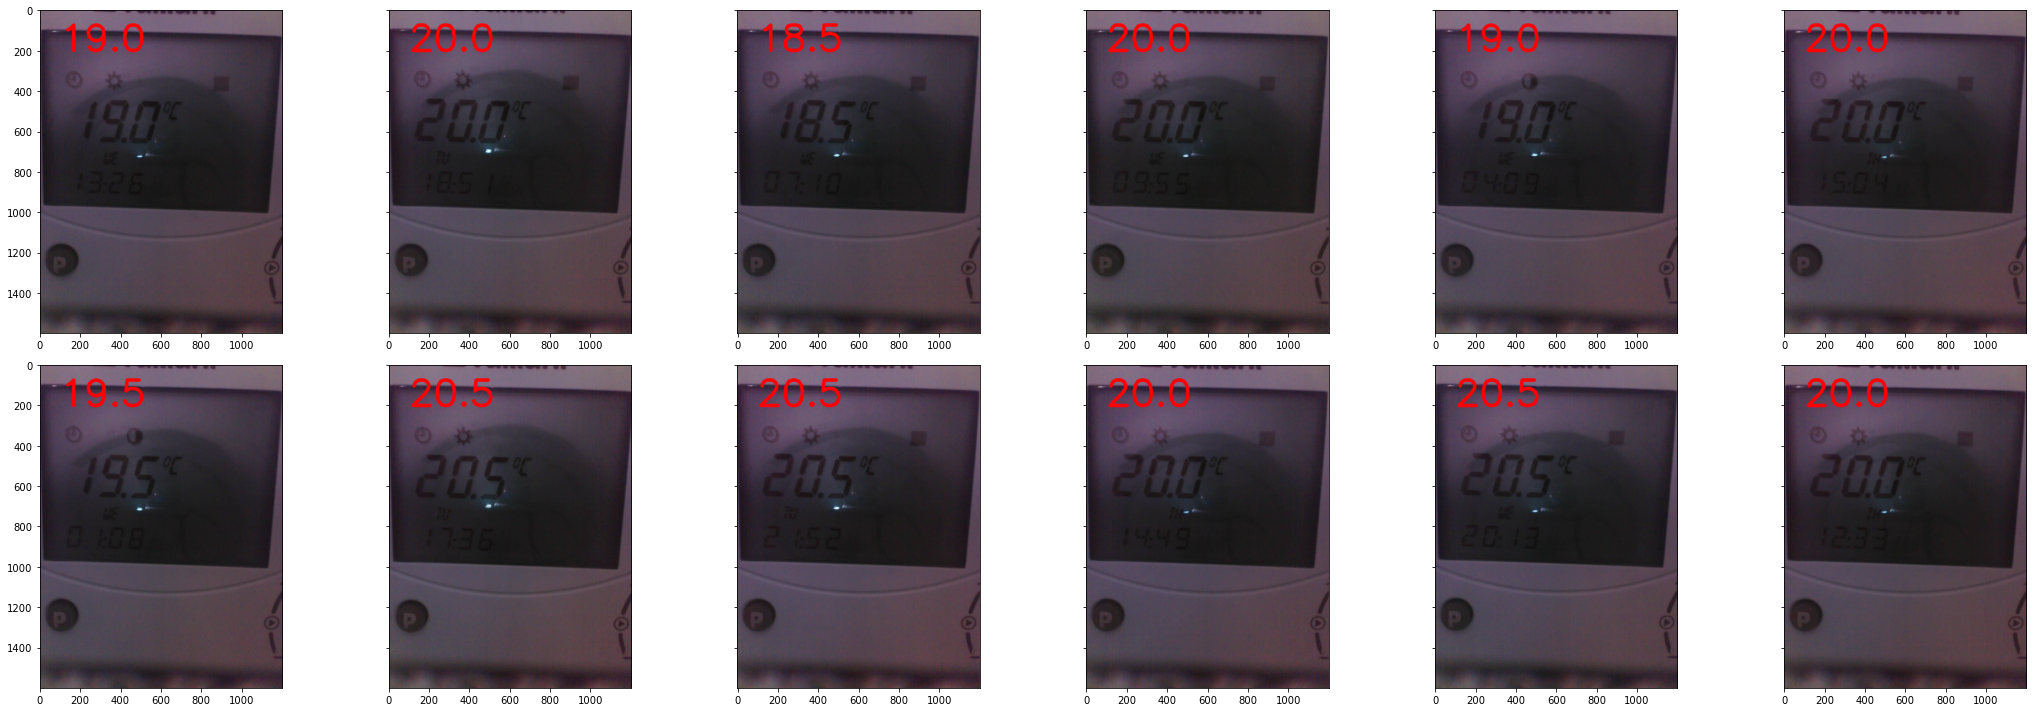

In [6]:
cvu.image_test(cam.dir_images, thermostat_temp_test, dir_path)

In [ ]:
cvu.image_test(cam.dir_images, thermostat_temp_test, "/home/aleks/Documents/my_documents/home/Aachen/Utilities/app/static/uploads/devices/Kar39EGThermostat/photos/")